<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:59:03] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


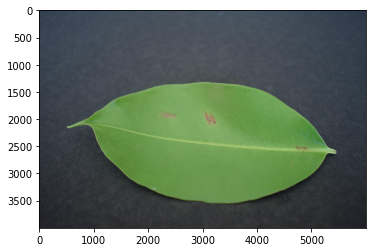

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

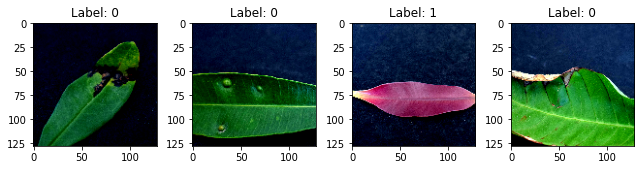

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:59:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:59:11] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2543012364094506 samples/sec                   batch loss = 0.8990640044212341 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2642224894425933 samples/sec                   batch loss = 0.9506894946098328 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2276604278045518 samples/sec                   batch loss = 0.646307110786438 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2671655404292885 samples/sec                   batch loss = 0.8265200257301331 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2703790151263037 samples/sec                   batch loss = 0.25973740220069885 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2606842308069177 samples/sec                   batch loss = 0.5490696430206299 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2620425267575974 samples/sec                   batch loss = 0.30650466680526733 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2691334706968367 samples/sec                   batch loss = 0.38306403160095215 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.273841299199655 samples/sec                   batch loss = 0.6573485136032104 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2712101913723695 samples/sec                   batch loss = 0.28576675057411194 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2604842850955307 samples/sec                   batch loss = 0.6539298892021179 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2673303705010803 samples/sec                   batch loss = 0.8656349182128906 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2729828220475328 samples/sec                   batch loss = 0.5535436868667603 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2699698426732229 samples/sec                   batch loss = 0.4901409447193146 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2580661005229639 samples/sec                   batch loss = 0.13974891602993011 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.265232423227881 samples/sec                   batch loss = 0.15491268038749695 | accuracy = 0.65625


Epoch[1] Batch[85] Speed: 1.2663268352237669 samples/sec                   batch loss = 1.2383817434310913 | accuracy = 0.6558823529411765


Epoch[1] Batch[90] Speed: 1.2633038633995832 samples/sec                   batch loss = 1.1858630180358887 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.2708982886158688 samples/sec                   batch loss = 0.370247483253479 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.2621048074387773 samples/sec                   batch loss = 0.17225337028503418 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.273135933152156 samples/sec                   batch loss = 0.2946449816226959 | accuracy = 0.6619047619047619


Epoch[1] Batch[110] Speed: 1.274793529721599 samples/sec                   batch loss = 1.2373614311218262 | accuracy = 0.6613636363636364


Epoch[1] Batch[115] Speed: 1.2698512271538336 samples/sec                   batch loss = 0.8859511017799377 | accuracy = 0.6608695652173913


Epoch[1] Batch[120] Speed: 1.2611342695689596 samples/sec                   batch loss = 0.9333561658859253 | accuracy = 0.6666666666666666


Epoch[1] Batch[125] Speed: 1.2611747499482817 samples/sec                   batch loss = 0.2452266812324524 | accuracy = 0.668


Epoch[1] Batch[130] Speed: 1.2648141628413134 samples/sec                   batch loss = 0.5533263683319092 | accuracy = 0.6634615384615384


Epoch[1] Batch[135] Speed: 1.271153557949142 samples/sec                   batch loss = 0.2702048420906067 | accuracy = 0.6666666666666666


Epoch[1] Batch[140] Speed: 1.2649266891797648 samples/sec                   batch loss = 0.2936411499977112 | accuracy = 0.6732142857142858


Epoch[1] Batch[145] Speed: 1.2645803056194296 samples/sec                   batch loss = 0.2067519873380661 | accuracy = 0.6741379310344827


Epoch[1] Batch[150] Speed: 1.2628899189230143 samples/sec                   batch loss = 0.4371504783630371 | accuracy = 0.6733333333333333


Epoch[1] Batch[155] Speed: 1.2732127440754668 samples/sec                   batch loss = 0.08044350147247314 | accuracy = 0.6758064516129032


Epoch[1] Batch[160] Speed: 1.2733134335607919 samples/sec                   batch loss = 0.6056747436523438 | accuracy = 0.6734375


Epoch[1] Batch[165] Speed: 1.2741301669311547 samples/sec                   batch loss = 0.15687985718250275 | accuracy = 0.6742424242424242


Epoch[1] Batch[170] Speed: 1.2704421213422064 samples/sec                   batch loss = 0.4718238413333893 | accuracy = 0.6735294117647059


Epoch[1] Batch[175] Speed: 1.2672983008964187 samples/sec                   batch loss = 0.644481360912323 | accuracy = 0.6771428571428572


Epoch[1] Batch[180] Speed: 1.2747585629856122 samples/sec                   batch loss = 0.1739177405834198 | accuracy = 0.6805555555555556


Epoch[1] Batch[185] Speed: 1.2697974057018975 samples/sec                   batch loss = 0.417695015668869 | accuracy = 0.6864864864864865


Epoch[1] Batch[190] Speed: 1.2617811288798406 samples/sec                   batch loss = 0.4207576811313629 | accuracy = 0.6881578947368421


Epoch[1] Batch[195] Speed: 1.2574384995175147 samples/sec                   batch loss = 0.8796811699867249 | accuracy = 0.6858974358974359


Epoch[1] Batch[200] Speed: 1.2669979784328411 samples/sec                   batch loss = 0.3359076976776123 | accuracy = 0.6925


Epoch[1] Batch[205] Speed: 1.2659887598065327 samples/sec                   batch loss = 0.9973664879798889 | accuracy = 0.6926829268292682


Epoch[1] Batch[210] Speed: 1.2656886756760732 samples/sec                   batch loss = 0.17109568417072296 | accuracy = 0.6904761904761905


Epoch[1] Batch[215] Speed: 1.2651652540037097 samples/sec                   batch loss = 0.6077980995178223 | accuracy = 0.6895348837209302


Epoch[1] Batch[220] Speed: 1.261958894232252 samples/sec                   batch loss = 0.5125823616981506 | accuracy = 0.6920454545454545


Epoch[1] Batch[225] Speed: 1.2659422384033503 samples/sec                   batch loss = 1.1130043268203735 | accuracy = 0.6911111111111111


Epoch[1] Batch[230] Speed: 1.2637750040921316 samples/sec                   batch loss = 0.4994789958000183 | accuracy = 0.6934782608695652


Epoch[1] Batch[235] Speed: 1.2658355482215116 samples/sec                   batch loss = 0.9725530743598938 | accuracy = 0.6946808510638298


Epoch[1] Batch[240] Speed: 1.2675992446333046 samples/sec                   batch loss = 0.400015652179718 | accuracy = 0.6958333333333333


Epoch[1] Batch[245] Speed: 1.2641331384728245 samples/sec                   batch loss = 0.5015226006507874 | accuracy = 0.6959183673469388


Epoch[1] Batch[250] Speed: 1.2735474386707546 samples/sec                   batch loss = 0.8365780115127563 | accuracy = 0.695


Epoch[1] Batch[255] Speed: 1.2749943592276387 samples/sec                   batch loss = 0.19801095128059387 | accuracy = 0.696078431372549


Epoch[1] Batch[260] Speed: 1.2668899622407164 samples/sec                   batch loss = 1.1070348024368286 | accuracy = 0.6951923076923077


Epoch[1] Batch[265] Speed: 1.26607359613625 samples/sec                   batch loss = 0.7784008979797363 | accuracy = 0.6933962264150944


Epoch[1] Batch[270] Speed: 1.266487622935926 samples/sec                   batch loss = 0.911679208278656 | accuracy = 0.6916666666666667


Epoch[1] Batch[275] Speed: 1.2648674673143743 samples/sec                   batch loss = 0.7288589477539062 | accuracy = 0.6909090909090909


Epoch[1] Batch[280] Speed: 1.2744863529846464 samples/sec                   batch loss = 0.4296780824661255 | accuracy = 0.6901785714285714


Epoch[1] Batch[285] Speed: 1.2666382192007108 samples/sec                   batch loss = 0.6230832934379578 | accuracy = 0.6877192982456141


Epoch[1] Batch[290] Speed: 1.2655215994683626 samples/sec                   batch loss = 0.4638932943344116 | accuracy = 0.6862068965517242


Epoch[1] Batch[295] Speed: 1.2627027677949838 samples/sec                   batch loss = 0.40827545523643494 | accuracy = 0.6855932203389831


Epoch[1] Batch[300] Speed: 1.266051143974204 samples/sec                   batch loss = 1.6025781631469727 | accuracy = 0.6858333333333333


Epoch[1] Batch[305] Speed: 1.2659190267436193 samples/sec                   batch loss = 0.36448752880096436 | accuracy = 0.6877049180327869


Epoch[1] Batch[310] Speed: 1.2681057999466219 samples/sec                   batch loss = 0.6220694780349731 | accuracy = 0.6862903225806452


Epoch[1] Batch[315] Speed: 1.262755799404374 samples/sec                   batch loss = 0.9287338256835938 | accuracy = 0.6857142857142857


Epoch[1] Batch[320] Speed: 1.2674731238643826 samples/sec                   batch loss = 0.5611547231674194 | accuracy = 0.6828125


Epoch[1] Batch[325] Speed: 1.267541112960356 samples/sec                   batch loss = 1.3167158365249634 | accuracy = 0.6807692307692308


Epoch[1] Batch[330] Speed: 1.2706969187151471 samples/sec                   batch loss = 0.5541332960128784 | accuracy = 0.681060606060606


Epoch[1] Batch[335] Speed: 1.272768914584172 samples/sec                   batch loss = 0.6100945472717285 | accuracy = 0.6813432835820895


Epoch[1] Batch[340] Speed: 1.2621521866465613 samples/sec                   batch loss = 0.6744336485862732 | accuracy = 0.6801470588235294


Epoch[1] Batch[345] Speed: 1.2723392889400809 samples/sec                   batch loss = 0.4581510126590729 | accuracy = 0.6804347826086956


Epoch[1] Batch[350] Speed: 1.2659486384756957 samples/sec                   batch loss = 0.18122515082359314 | accuracy = 0.6821428571428572


Epoch[1] Batch[355] Speed: 1.2678142919680462 samples/sec                   batch loss = 0.5538985133171082 | accuracy = 0.680281690140845


Epoch[1] Batch[360] Speed: 1.2617844502505187 samples/sec                   batch loss = 0.873938798904419 | accuracy = 0.6805555555555556


Epoch[1] Batch[365] Speed: 1.264107516697766 samples/sec                   batch loss = 0.4434291124343872 | accuracy = 0.6835616438356165


Epoch[1] Batch[370] Speed: 1.264224680509888 samples/sec                   batch loss = 0.146652489900589 | accuracy = 0.6831081081081081


Epoch[1] Batch[375] Speed: 1.2633411535932584 samples/sec                   batch loss = 0.3383414149284363 | accuracy = 0.6833333333333333


Epoch[1] Batch[380] Speed: 1.2622846584167164 samples/sec                   batch loss = 0.5500870943069458 | accuracy = 0.6828947368421052


Epoch[1] Batch[385] Speed: 1.2500206570760712 samples/sec                   batch loss = 0.21766038239002228 | accuracy = 0.685064935064935


Epoch[1] Batch[390] Speed: 1.2678343156775365 samples/sec                   batch loss = 0.3484336733818054 | accuracy = 0.6865384615384615


Epoch[1] Batch[395] Speed: 1.273954180003452 samples/sec                   batch loss = 2.757655143737793 | accuracy = 0.6841772151898734


Epoch[1] Batch[400] Speed: 1.270775649443436 samples/sec                   batch loss = 0.581235945224762 | accuracy = 0.684375


Epoch[1] Batch[405] Speed: 1.2745044579733824 samples/sec                   batch loss = 0.7283467054367065 | accuracy = 0.6845679012345679


Epoch[1] Batch[410] Speed: 1.2671129033890396 samples/sec                   batch loss = 0.5022342801094055 | accuracy = 0.6841463414634147


Epoch[1] Batch[415] Speed: 1.2681246826327734 samples/sec                   batch loss = 1.0652281045913696 | accuracy = 0.6837349397590361


Epoch[1] Batch[420] Speed: 1.2713465946127487 samples/sec                   batch loss = 0.4111427962779999 | accuracy = 0.6833333333333333


Epoch[1] Batch[425] Speed: 1.2679574418590767 samples/sec                   batch loss = 0.2036692053079605 | accuracy = 0.6829411764705883


Epoch[1] Batch[430] Speed: 1.270984843377017 samples/sec                   batch loss = 0.4810558259487152 | accuracy = 0.6837209302325581


Epoch[1] Batch[435] Speed: 1.2666021684535793 samples/sec                   batch loss = 0.1907016485929489 | accuracy = 0.6862068965517242


Epoch[1] Batch[440] Speed: 1.2673542083632818 samples/sec                   batch loss = 0.6139644384384155 | accuracy = 0.6863636363636364


Epoch[1] Batch[445] Speed: 1.2718134384307553 samples/sec                   batch loss = 0.40820807218551636 | accuracy = 0.6876404494382022


Epoch[1] Batch[450] Speed: 1.2716169830117736 samples/sec                   batch loss = 0.7829680442810059 | accuracy = 0.6861111111111111


Epoch[1] Batch[455] Speed: 1.2675001271110156 samples/sec                   batch loss = 0.8268388509750366 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2623075470377876 samples/sec                   batch loss = 0.48129984736442566 | accuracy = 0.6847826086956522


Epoch[1] Batch[465] Speed: 1.272548901520076 samples/sec                   batch loss = 0.47648733854293823 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2747000633732868 samples/sec                   batch loss = 0.7380825877189636 | accuracy = 0.6851063829787234


Epoch[1] Batch[475] Speed: 1.2728723344528579 samples/sec                   batch loss = 0.5259383916854858 | accuracy = 0.6868421052631579


Epoch[1] Batch[480] Speed: 1.2641481881780572 samples/sec                   batch loss = 0.431934654712677 | accuracy = 0.6864583333333333


Epoch[1] Batch[485] Speed: 1.2621040478812504 samples/sec                   batch loss = 0.9865440726280212 | accuracy = 0.6850515463917526


Epoch[1] Batch[490] Speed: 1.2748424476264733 samples/sec                   batch loss = 0.36964038014411926 | accuracy = 0.685204081632653


Epoch[1] Batch[495] Speed: 1.2674209399991903 samples/sec                   batch loss = 0.19682911038398743 | accuracy = 0.6848484848484848


Epoch[1] Batch[500] Speed: 1.2706789217401526 samples/sec                   batch loss = 0.6442818641662598 | accuracy = 0.6845


Epoch[1] Batch[505] Speed: 1.2727339622754585 samples/sec                   batch loss = 0.6678208112716675 | accuracy = 0.6861386138613862


Epoch[1] Batch[510] Speed: 1.2704283644223453 samples/sec                   batch loss = 0.8952827453613281 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.2696313568345425 samples/sec                   batch loss = 0.4584154188632965 | accuracy = 0.6873786407766991


Epoch[1] Batch[520] Speed: 1.2670959647625428 samples/sec                   batch loss = 0.5523735284805298 | accuracy = 0.6875


Epoch[1] Batch[525] Speed: 1.2708337893969879 samples/sec                   batch loss = 0.9051032066345215 | accuracy = 0.6871428571428572


Epoch[1] Batch[530] Speed: 1.2614597029453656 samples/sec                   batch loss = 0.9013782739639282 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2671180711957568 samples/sec                   batch loss = 0.5658670663833618 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2701281914332672 samples/sec                   batch loss = 0.7579761147499084 | accuracy = 0.6851851851851852


Epoch[1] Batch[545] Speed: 1.2756367019456232 samples/sec                   batch loss = 0.5191160440444946 | accuracy = 0.6848623853211009


Epoch[1] Batch[550] Speed: 1.2648897821487801 samples/sec                   batch loss = 0.25248321890830994 | accuracy = 0.685


Epoch[1] Batch[555] Speed: 1.2719283708169697 samples/sec                   batch loss = 0.8354825973510742 | accuracy = 0.6846846846846847


Epoch[1] Batch[560] Speed: 1.276341444061673 samples/sec                   batch loss = 0.3504352867603302 | accuracy = 0.6861607142857142


Epoch[1] Batch[565] Speed: 1.272459913895232 samples/sec                   batch loss = 0.2528805732727051 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.2756621142506206 samples/sec                   batch loss = 0.7683622241020203 | accuracy = 0.6859649122807018


Epoch[1] Batch[575] Speed: 1.2711509575559847 samples/sec                   batch loss = 0.6862161159515381 | accuracy = 0.6869565217391305


Epoch[1] Batch[580] Speed: 1.2656006448845143 samples/sec                   batch loss = 0.34614524245262146 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.26903363315635 samples/sec                   batch loss = 0.19181960821151733 | accuracy = 0.6858974358974359


Epoch[1] Batch[590] Speed: 1.270024544004077 samples/sec                   batch loss = 0.6883317828178406 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2667432274996848 samples/sec                   batch loss = 0.24156485497951508 | accuracy = 0.6869747899159664


Epoch[1] Batch[600] Speed: 1.2611503855678805 samples/sec                   batch loss = 0.42305874824523926 | accuracy = 0.6875


Epoch[1] Batch[605] Speed: 1.2662564914904841 samples/sec                   batch loss = 0.34529998898506165 | accuracy = 0.6896694214876034


Epoch[1] Batch[610] Speed: 1.2744609875019808 samples/sec                   batch loss = 0.3051106035709381 | accuracy = 0.6893442622950819


Epoch[1] Batch[615] Speed: 1.2745000042920858 samples/sec                   batch loss = 0.6382318139076233 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.2632256752941176 samples/sec                   batch loss = 0.7312349677085876 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2574875082962602 samples/sec                   batch loss = 1.0356500148773193 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2619999971415996 samples/sec                   batch loss = 0.652998149394989 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2750056959198064 samples/sec                   batch loss = 0.7416187524795532 | accuracy = 0.6909448818897638


Epoch[1] Batch[640] Speed: 1.2739697546753261 samples/sec                   batch loss = 0.6194252967834473 | accuracy = 0.69140625


Epoch[1] Batch[645] Speed: 1.2711153236104908 samples/sec                   batch loss = 0.344375342130661 | accuracy = 0.6926356589147287


Epoch[1] Batch[650] Speed: 1.2661038839313812 samples/sec                   batch loss = 0.725689709186554 | accuracy = 0.6923076923076923


Epoch[1] Batch[655] Speed: 1.2794266241462529 samples/sec                   batch loss = 0.6238328814506531 | accuracy = 0.6923664122137405


Epoch[1] Batch[660] Speed: 1.2763768861065308 samples/sec                   batch loss = 0.4840499758720398 | accuracy = 0.6920454545454545


Epoch[1] Batch[665] Speed: 1.2716501390406498 samples/sec                   batch loss = 0.5098183751106262 | accuracy = 0.693609022556391


Epoch[1] Batch[670] Speed: 1.2671380729190544 samples/sec                   batch loss = 0.23528096079826355 | accuracy = 0.6947761194029851


Epoch[1] Batch[675] Speed: 1.269237452833536 samples/sec                   batch loss = 0.5158500671386719 | accuracy = 0.6948148148148148


Epoch[1] Batch[680] Speed: 1.2762393043022107 samples/sec                   batch loss = 0.4095354974269867 | accuracy = 0.6952205882352941


Epoch[1] Batch[685] Speed: 1.2740545997927608 samples/sec                   batch loss = 0.6607747673988342 | accuracy = 0.6945255474452555


Epoch[1] Batch[690] Speed: 1.275963162200156 samples/sec                   batch loss = 0.44646742939949036 | accuracy = 0.6945652173913044


Epoch[1] Batch[695] Speed: 1.2645875497957442 samples/sec                   batch loss = 0.40504446625709534 | accuracy = 0.6949640287769784


Epoch[1] Batch[700] Speed: 1.274351985508563 samples/sec                   batch loss = 0.5736535787582397 | accuracy = 0.6957142857142857


Epoch[1] Batch[705] Speed: 1.2737077445854452 samples/sec                   batch loss = 0.7068704962730408 | accuracy = 0.6953900709219858


Epoch[1] Batch[710] Speed: 1.2711330440255508 samples/sec                   batch loss = 0.50333571434021 | accuracy = 0.694718309859155


Epoch[1] Batch[715] Speed: 1.2750526920502017 samples/sec                   batch loss = 0.38555341958999634 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.2652412015511505 samples/sec                   batch loss = 0.28871941566467285 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.275964617820548 samples/sec                   batch loss = 0.7242116332054138 | accuracy = 0.696551724137931


Epoch[1] Batch[730] Speed: 1.27655985662417 samples/sec                   batch loss = 0.8454070687294006 | accuracy = 0.6972602739726027


Epoch[1] Batch[735] Speed: 1.272575349265364 samples/sec                   batch loss = 0.33540210127830505 | accuracy = 0.6979591836734694


Epoch[1] Batch[740] Speed: 1.274736479719627 samples/sec                   batch loss = 0.21325302124023438 | accuracy = 0.6989864864864865


Epoch[1] Batch[745] Speed: 1.2627495266161473 samples/sec                   batch loss = 0.2858656346797943 | accuracy = 0.6996644295302014


Epoch[1] Batch[750] Speed: 1.2658500654344838 samples/sec                   batch loss = 0.5311627388000488 | accuracy = 0.7003333333333334


Epoch[1] Batch[755] Speed: 1.2705349642903772 samples/sec                   batch loss = 0.5428824424743652 | accuracy = 0.7009933774834437


Epoch[1] Batch[760] Speed: 1.2724606859686034 samples/sec                   batch loss = 0.7539361119270325 | accuracy = 0.7


Epoch[1] Batch[765] Speed: 1.2558955478450968 samples/sec                   batch loss = 0.3881267309188843 | accuracy = 0.7003267973856209


Epoch[1] Batch[770] Speed: 1.2639646633871964 samples/sec                   batch loss = 0.46075940132141113 | accuracy = 0.701948051948052


Epoch[1] Batch[775] Speed: 1.267984369915034 samples/sec                   batch loss = 0.5791860818862915 | accuracy = 0.7019354838709677


Epoch[1] Batch[780] Speed: 1.269268564374132 samples/sec                   batch loss = 0.6181508898735046 | accuracy = 0.701602564102564


Epoch[1] Batch[785] Speed: 1.2698218170093534 samples/sec                   batch loss = 0.7745780944824219 | accuracy = 0.7019108280254777


[Epoch 1] training: accuracy=0.7014593908629442
[Epoch 1] time cost: 649.2942428588867
[Epoch 1] validation: validation accuracy=0.7366666666666667


Epoch[2] Batch[5] Speed: 1.2707185735051658 samples/sec                   batch loss = 0.6162664294242859 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2754682497869432 samples/sec                   batch loss = 0.39837777614593506 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.279663565014264 samples/sec                   batch loss = 0.43135207891464233 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2758102435209566 samples/sec                   batch loss = 0.5223474502563477 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2654201341386904 samples/sec                   batch loss = 0.9232763648033142 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2702370490601071 samples/sec                   batch loss = 0.7498156428337097 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.2759633562826829 samples/sec                   batch loss = 0.42844584584236145 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2748760626996598 samples/sec                   batch loss = 0.42358633875846863 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2686872035520667 samples/sec                   batch loss = 0.9784239530563354 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2706486071327328 samples/sec                   batch loss = 0.22704972326755524 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2788133082376028 samples/sec                   batch loss = 0.4959019720554352 | accuracy = 0.7090909090909091


Epoch[2] Batch[60] Speed: 1.2763597959980775 samples/sec                   batch loss = 0.22085243463516235 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.272465607958371 samples/sec                   batch loss = 0.6909281015396118 | accuracy = 0.7076923076923077


Epoch[2] Batch[70] Speed: 1.2705507441301114 samples/sec                   batch loss = 0.5469936728477478 | accuracy = 0.7107142857142857


Epoch[2] Batch[75] Speed: 1.2599452876722883 samples/sec                   batch loss = 0.2235211282968521 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2708929936572069 samples/sec                   batch loss = 0.6006788611412048 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.272235183868111 samples/sec                   batch loss = 1.4347410202026367 | accuracy = 0.7147058823529412


Epoch[2] Batch[90] Speed: 1.269155264248613 samples/sec                   batch loss = 0.17304714024066925 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.2675502106461967 samples/sec                   batch loss = 0.61292964220047 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.2706560172365295 samples/sec                   batch loss = 0.7255467176437378 | accuracy = 0.7175


Epoch[2] Batch[105] Speed: 1.2749430075060098 samples/sec                   batch loss = 0.5976836681365967 | accuracy = 0.7166666666666667


Epoch[2] Batch[110] Speed: 1.276437676224039 samples/sec                   batch loss = 0.4384644031524658 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2775920384431687 samples/sec                   batch loss = 0.9757137894630432 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.2612611230980872 samples/sec                   batch loss = 1.0586278438568115 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.2721538606191671 samples/sec                   batch loss = 0.32787325978279114 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.268732967477311 samples/sec                   batch loss = 0.4916483461856842 | accuracy = 0.7211538461538461


Epoch[2] Batch[135] Speed: 1.2747851026596446 samples/sec                   batch loss = 0.3053039312362671 | accuracy = 0.7203703703703703


Epoch[2] Batch[140] Speed: 1.2698405586106336 samples/sec                   batch loss = 0.3016969561576843 | accuracy = 0.7232142857142857


Epoch[2] Batch[145] Speed: 1.2684972753782382 samples/sec                   batch loss = 0.335143506526947 | accuracy = 0.7258620689655172


Epoch[2] Batch[150] Speed: 1.2782729388828524 samples/sec                   batch loss = 1.1875810623168945 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2703790151263037 samples/sec                   batch loss = 0.8238911628723145 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2734789003878606 samples/sec                   batch loss = 0.2676420211791992 | accuracy = 0.725


Epoch[2] Batch[165] Speed: 1.266171726206738 samples/sec                   batch loss = 0.25861990451812744 | accuracy = 0.7272727272727273


Epoch[2] Batch[170] Speed: 1.2682002190011545 samples/sec                   batch loss = 0.6495122909545898 | accuracy = 0.7235294117647059


Epoch[2] Batch[175] Speed: 1.2773663674382285 samples/sec                   batch loss = 1.0660595893859863 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2664589419931227 samples/sec                   batch loss = 0.6472718119621277 | accuracy = 0.7263888888888889


Epoch[2] Batch[185] Speed: 1.2698882320487446 samples/sec                   batch loss = 1.0658810138702393 | accuracy = 0.7297297297297297


Epoch[2] Batch[190] Speed: 1.262506456557153 samples/sec                   batch loss = 0.6989728212356567 | accuracy = 0.7289473684210527


Epoch[2] Batch[195] Speed: 1.2651008583904584 samples/sec                   batch loss = 0.27403247356414795 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2700373307591253 samples/sec                   batch loss = 0.19512562453746796 | accuracy = 0.73125


Epoch[2] Batch[205] Speed: 1.2671203680122727 samples/sec                   batch loss = 0.3927922248840332 | accuracy = 0.7292682926829268


Epoch[2] Batch[210] Speed: 1.2553590578485831 samples/sec                   batch loss = 0.35088643431663513 | accuracy = 0.7309523809523809


Epoch[2] Batch[215] Speed: 1.2514192501859724 samples/sec                   batch loss = 0.6875689029693604 | accuracy = 0.7302325581395349


Epoch[2] Batch[220] Speed: 1.2569613349076676 samples/sec                   batch loss = 1.2301089763641357 | accuracy = 0.7329545454545454


Epoch[2] Batch[225] Speed: 1.2680592186688082 samples/sec                   batch loss = 0.27217599749565125 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2730154697804419 samples/sec                   batch loss = 0.8491084575653076 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2602482394911056 samples/sec                   batch loss = 0.403323769569397 | accuracy = 0.7361702127659574


Epoch[2] Batch[240] Speed: 1.2573084562778618 samples/sec                   batch loss = 0.3875780999660492 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2661606416197952 samples/sec                   batch loss = 0.22715748846530914 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2707618852994806 samples/sec                   batch loss = 0.34076589345932007 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.268748894481486 samples/sec                   batch loss = 0.3073497414588928 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.2677627505918783 samples/sec                   batch loss = 0.42770931124687195 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2622062165771126 samples/sec                   batch loss = 0.5410428047180176 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.2639857084135446 samples/sec                   batch loss = 0.7900229692459106 | accuracy = 0.7425925925925926


Epoch[2] Batch[275] Speed: 1.2712854214605098 samples/sec                   batch loss = 0.6356507539749146 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.2712504542557284 samples/sec                   batch loss = 0.13613088428974152 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2613745354488144 samples/sec                   batch loss = 1.1275553703308105 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.262364534762545 samples/sec                   batch loss = 0.4964384436607361 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.2737677004700587 samples/sec                   batch loss = 0.470954954624176 | accuracy = 0.7398305084745763


Epoch[2] Batch[300] Speed: 1.274925568239632 samples/sec                   batch loss = 0.47172701358795166 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.276727528530235 samples/sec                   batch loss = 0.5928996801376343 | accuracy = 0.7401639344262295


Epoch[2] Batch[310] Speed: 1.2645019594365174 samples/sec                   batch loss = 0.2437252700328827 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2776833022033565 samples/sec                   batch loss = 0.2921749949455261 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.2710884550106243 samples/sec                   batch loss = 0.4870677590370178 | accuracy = 0.73984375


Epoch[2] Batch[325] Speed: 1.2693655576689098 samples/sec                   batch loss = 0.3422762453556061 | accuracy = 0.7369230769230769


Epoch[2] Batch[330] Speed: 1.2595268273057576 samples/sec                   batch loss = 0.3657081723213196 | accuracy = 0.7378787878787879


Epoch[2] Batch[335] Speed: 1.2596224319672245 samples/sec                   batch loss = 0.5696020126342773 | accuracy = 0.7380597014925373


Epoch[2] Batch[340] Speed: 1.2666798187667785 samples/sec                   batch loss = 0.6508626341819763 | accuracy = 0.7382352941176471


Epoch[2] Batch[345] Speed: 1.2689001249975702 samples/sec                   batch loss = 0.46083298325538635 | accuracy = 0.7398550724637681


Epoch[2] Batch[350] Speed: 1.2676023093834607 samples/sec                   batch loss = 0.9187589287757874 | accuracy = 0.74


Epoch[2] Batch[355] Speed: 1.267103620582839 samples/sec                   batch loss = 0.9687949419021606 | accuracy = 0.7373239436619718


Epoch[2] Batch[360] Speed: 1.263246505485907 samples/sec                   batch loss = 0.20040960609912872 | accuracy = 0.7388888888888889


Epoch[2] Batch[365] Speed: 1.267427067790044 samples/sec                   batch loss = 0.3400615453720093 | accuracy = 0.7383561643835617


Epoch[2] Batch[370] Speed: 1.2692958362382056 samples/sec                   batch loss = 0.25683319568634033 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.2711883271908888 samples/sec                   batch loss = 0.39155980944633484 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.2583041605328535 samples/sec                   batch loss = 0.18390439450740814 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.262785548475942 samples/sec                   batch loss = 0.8654748797416687 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.2676664809934834 samples/sec                   batch loss = 0.7016623020172119 | accuracy = 0.7410256410256411


Epoch[2] Batch[395] Speed: 1.2724307688107168 samples/sec                   batch loss = 0.6108748912811279 | accuracy = 0.7424050632911392


Epoch[2] Batch[400] Speed: 1.266064041927408 samples/sec                   batch loss = 0.5513331890106201 | accuracy = 0.741875


Epoch[2] Batch[405] Speed: 1.2589155276830661 samples/sec                   batch loss = 0.2295326292514801 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.263025398099697 samples/sec                   batch loss = 1.0725270509719849 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.2678056695128515 samples/sec                   batch loss = 0.21463823318481445 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.267932239768137 samples/sec                   batch loss = 0.32117441296577454 | accuracy = 0.7422619047619048


Epoch[2] Batch[425] Speed: 1.2694480616518427 samples/sec                   batch loss = 0.4074711203575134 | accuracy = 0.741764705882353


Epoch[2] Batch[430] Speed: 1.2590061266290062 samples/sec                   batch loss = 0.6849867105484009 | accuracy = 0.7418604651162791


Epoch[2] Batch[435] Speed: 1.26650559698887 samples/sec                   batch loss = 0.5252085328102112 | accuracy = 0.7413793103448276


Epoch[2] Batch[440] Speed: 1.2673375504856832 samples/sec                   batch loss = 0.6497423052787781 | accuracy = 0.7420454545454546


Epoch[2] Batch[445] Speed: 1.268498809923454 samples/sec                   batch loss = 1.066590428352356 | accuracy = 0.7426966292134831


Epoch[2] Batch[450] Speed: 1.265442468477862 samples/sec                   batch loss = 0.6544052958488464 | accuracy = 0.7411111111111112


Epoch[2] Batch[455] Speed: 1.2586531571816766 samples/sec                   batch loss = 0.2309284210205078 | accuracy = 0.7428571428571429


Epoch[2] Batch[460] Speed: 1.2711282286464838 samples/sec                   batch loss = 0.7094383835792542 | accuracy = 0.7418478260869565


Epoch[2] Batch[465] Speed: 1.2700344465061746 samples/sec                   batch loss = 1.5673067569732666 | accuracy = 0.7413978494623656


Epoch[2] Batch[470] Speed: 1.2660505707379386 samples/sec                   batch loss = 0.29325082898139954 | accuracy = 0.7414893617021276


Epoch[2] Batch[475] Speed: 1.2606883042589254 samples/sec                   batch loss = 0.22820310294628143 | accuracy = 0.7426315789473684


Epoch[2] Batch[480] Speed: 1.2646481753669125 samples/sec                   batch loss = 0.6292732954025269 | accuracy = 0.740625


Epoch[2] Batch[485] Speed: 1.2667597741108805 samples/sec                   batch loss = 0.54537433385849 | accuracy = 0.7412371134020619


Epoch[2] Batch[490] Speed: 1.266781294916661 samples/sec                   batch loss = 0.404573917388916 | accuracy = 0.7408163265306122


Epoch[2] Batch[495] Speed: 1.2684795324688247 samples/sec                   batch loss = 0.4835106134414673 | accuracy = 0.7429292929292929


Epoch[2] Batch[500] Speed: 1.25773741821476 samples/sec                   batch loss = 0.7404366731643677 | accuracy = 0.742


Epoch[2] Batch[505] Speed: 1.2603386516480686 samples/sec                   batch loss = 0.7810857892036438 | accuracy = 0.7410891089108911


Epoch[2] Batch[510] Speed: 1.2697957719077442 samples/sec                   batch loss = 0.3976134657859802 | accuracy = 0.7411764705882353


Epoch[2] Batch[515] Speed: 1.264506915355101 samples/sec                   batch loss = 0.38307681679725647 | accuracy = 0.7407766990291262


Epoch[2] Batch[520] Speed: 1.2623943603895742 samples/sec                   batch loss = 1.1149265766143799 | accuracy = 0.7403846153846154


Epoch[2] Batch[525] Speed: 1.2597794404419662 samples/sec                   batch loss = 0.5761888027191162 | accuracy = 0.74


Epoch[2] Batch[530] Speed: 1.263918385839475 samples/sec                   batch loss = 0.4468270540237427 | accuracy = 0.7415094339622641


Epoch[2] Batch[535] Speed: 1.2701692512616358 samples/sec                   batch loss = 0.5821051597595215 | accuracy = 0.7406542056074766


Epoch[2] Batch[540] Speed: 1.2766991591563803 samples/sec                   batch loss = 0.33607935905456543 | accuracy = 0.7407407407407407


Epoch[2] Batch[545] Speed: 1.2590596040763677 samples/sec                   batch loss = 1.216934084892273 | accuracy = 0.7403669724770642


Epoch[2] Batch[550] Speed: 1.2542767617961952 samples/sec                   batch loss = 0.36822518706321716 | accuracy = 0.7418181818181818


Epoch[2] Batch[555] Speed: 1.2714710784788499 samples/sec                   batch loss = 0.11253149062395096 | accuracy = 0.7432432432432432


Epoch[2] Batch[560] Speed: 1.2682191044993192 samples/sec                   batch loss = 0.29888251423835754 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.2749856388323844 samples/sec                   batch loss = 0.7353521585464478 | accuracy = 0.7424778761061946


Epoch[2] Batch[570] Speed: 1.2675903377872828 samples/sec                   batch loss = 0.28264471888542175 | accuracy = 0.7429824561403509


Epoch[2] Batch[575] Speed: 1.2640515143521909 samples/sec                   batch loss = 0.5063267350196838 | accuracy = 0.7430434782608696


Epoch[2] Batch[580] Speed: 1.2676342985978153 samples/sec                   batch loss = 0.1423473358154297 | accuracy = 0.7439655172413793


Epoch[2] Batch[585] Speed: 1.2685533846015768 samples/sec                   batch loss = 0.47232991456985474 | accuracy = 0.7431623931623932


Epoch[2] Batch[590] Speed: 1.2740757886493663 samples/sec                   batch loss = 0.5281543731689453 | accuracy = 0.7427966101694915


Epoch[2] Batch[595] Speed: 1.2657399530497022 samples/sec                   batch loss = 0.6353853940963745 | accuracy = 0.7420168067226891


Epoch[2] Batch[600] Speed: 1.2636523080997284 samples/sec                   batch loss = 0.6260976791381836 | accuracy = 0.7425


Epoch[2] Batch[605] Speed: 1.2677934066674783 samples/sec                   batch loss = 0.3618774116039276 | accuracy = 0.7413223140495868


Epoch[2] Batch[610] Speed: 1.2705300572249911 samples/sec                   batch loss = 0.2855033278465271 | accuracy = 0.7430327868852459


Epoch[2] Batch[615] Speed: 1.2646774416772375 samples/sec                   batch loss = 0.7133430242538452 | accuracy = 0.7426829268292683


Epoch[2] Batch[620] Speed: 1.2643578735578522 samples/sec                   batch loss = 0.5154474973678589 | accuracy = 0.7423387096774193


Epoch[2] Batch[625] Speed: 1.2693091845143398 samples/sec                   batch loss = 0.27720603346824646 | accuracy = 0.7436


Epoch[2] Batch[630] Speed: 1.2677951311157745 samples/sec                   batch loss = 0.589270830154419 | accuracy = 0.7436507936507937


Epoch[2] Batch[635] Speed: 1.2674722620775851 samples/sec                   batch loss = 0.24559469521045685 | accuracy = 0.7440944881889764


Epoch[2] Batch[640] Speed: 1.259473121063634 samples/sec                   batch loss = 0.6109874844551086 | accuracy = 0.74453125


Epoch[2] Batch[645] Speed: 1.2629168222991942 samples/sec                   batch loss = 1.12074875831604 | accuracy = 0.7430232558139535


Epoch[2] Batch[650] Speed: 1.2737085181738184 samples/sec                   batch loss = 0.20614102482795715 | accuracy = 0.7442307692307693


Epoch[2] Batch[655] Speed: 1.2736957540858218 samples/sec                   batch loss = 0.5427514314651489 | accuracy = 0.7435114503816794


Epoch[2] Batch[660] Speed: 1.2645938408582997 samples/sec                   batch loss = 0.8523690104484558 | accuracy = 0.7431818181818182


Epoch[2] Batch[665] Speed: 1.2628022770040848 samples/sec                   batch loss = 0.5788552165031433 | accuracy = 0.7439849624060151


Epoch[2] Batch[670] Speed: 1.2617762891995836 samples/sec                   batch loss = 0.5183020234107971 | accuracy = 0.7440298507462687


Epoch[2] Batch[675] Speed: 1.2705245729026504 samples/sec                   batch loss = 1.1612263917922974 | accuracy = 0.7440740740740741


Epoch[2] Batch[680] Speed: 1.2726764206673558 samples/sec                   batch loss = 0.3713368773460388 | accuracy = 0.7441176470588236


Epoch[2] Batch[685] Speed: 1.2749025103865184 samples/sec                   batch loss = 0.24738922715187073 | accuracy = 0.7437956204379562


Epoch[2] Batch[690] Speed: 1.2641427588126992 samples/sec                   batch loss = 0.2663588523864746 | accuracy = 0.743840579710145


Epoch[2] Batch[695] Speed: 1.2661989607143755 samples/sec                   batch loss = 0.33142223954200745 | accuracy = 0.7438848920863309


Epoch[2] Batch[700] Speed: 1.274093107918633 samples/sec                   batch loss = 0.5747354030609131 | accuracy = 0.7446428571428572


Epoch[2] Batch[705] Speed: 1.2687511012666173 samples/sec                   batch loss = 0.4052310585975647 | accuracy = 0.7429078014184397


Epoch[2] Batch[710] Speed: 1.2701354031547283 samples/sec                   batch loss = 0.2974216043949127 | accuracy = 0.7429577464788732


Epoch[2] Batch[715] Speed: 1.2596007754362015 samples/sec                   batch loss = 0.5563066005706787 | accuracy = 0.7433566433566433


Epoch[2] Batch[720] Speed: 1.2709266896016855 samples/sec                   batch loss = 0.4582691192626953 | accuracy = 0.74375


Epoch[2] Batch[725] Speed: 1.2701754056567163 samples/sec                   batch loss = 0.29630911350250244 | accuracy = 0.743448275862069


Epoch[2] Batch[730] Speed: 1.2631866799782556 samples/sec                   batch loss = 0.22861148416996002 | accuracy = 0.7441780821917808


Epoch[2] Batch[735] Speed: 1.2596694358214682 samples/sec                   batch loss = 0.34370461106300354 | accuracy = 0.7438775510204082


Epoch[2] Batch[740] Speed: 1.2637307394081716 samples/sec                   batch loss = 0.9454321265220642 | accuracy = 0.7439189189189189


Epoch[2] Batch[745] Speed: 1.268040817131701 samples/sec                   batch loss = 0.34474319219589233 | accuracy = 0.7446308724832215


Epoch[2] Batch[750] Speed: 1.2678427469023381 samples/sec                   batch loss = 0.4315727651119232 | accuracy = 0.743


Epoch[2] Batch[755] Speed: 1.2709729040883484 samples/sec                   batch loss = 0.335111528635025 | accuracy = 0.743046357615894


Epoch[2] Batch[760] Speed: 1.262191782821247 samples/sec                   batch loss = 0.3568193018436432 | accuracy = 0.7440789473684211


Epoch[2] Batch[765] Speed: 1.2632889289138995 samples/sec                   batch loss = 0.4491789638996124 | accuracy = 0.7447712418300654


Epoch[2] Batch[770] Speed: 1.2694333657453223 samples/sec                   batch loss = 0.7777905464172363 | accuracy = 0.7454545454545455


Epoch[2] Batch[775] Speed: 1.2688700871339575 samples/sec                   batch loss = 0.283366858959198 | accuracy = 0.7458064516129033


Epoch[2] Batch[780] Speed: 1.270030985419926 samples/sec                   batch loss = 0.6417022347450256 | accuracy = 0.7451923076923077


Epoch[2] Batch[785] Speed: 1.263489004240093 samples/sec                   batch loss = 0.3840572237968445 | accuracy = 0.7452229299363057


[Epoch 2] training: accuracy=0.745241116751269
[Epoch 2] time cost: 639.4175269603729
[Epoch 2] validation: validation accuracy=0.7922222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7955555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)